# Project 2: Mini deep-learning framework

In [1]:
#!/usr/bin/env python3
""" File to solve the second miniproject which is the design of a framework """

import math
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import empty

__author__ = 'Eugène Lemaitre, Natalie Bolón Brun, Louis Munier'
__version__ = '0.1'

torch.set_grad_enabled(False)

# Data generation and plotting

In [2]:
def generate_disc_set(nb):
    X = empty(nb,2).uniform_(0,1)
    Y = empty(X.size())
    
    Y[:,0] = ( (X - 0.5).norm(dim=1)  >  math.sqrt(1/(2*math.pi)) ).type(torch.LongTensor)
    Y[:,1] = ( (X - 0.5).norm(dim=1)  <=  math.sqrt(1/(2*math.pi)) ).type(torch.LongTensor)
    
    return X, Y

def plot_disc(data_in, data_target, title):
    plt.scatter(data_in[(data_target[:,1]==1),0] ,data_in[(data_target[:,1]==1),1], color = "c", s=20)
    plt.scatter(data_in[(data_target[:,1]==0),0] ,data_in[(data_target[:,1]==0),1], color = "g", s=20)
    plt.title(title)
    plt.legend(["1", "0"] )
    plt.show()

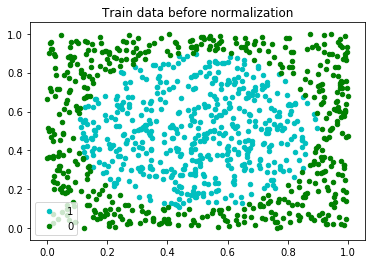

Point outside:  498
Point inside:   502


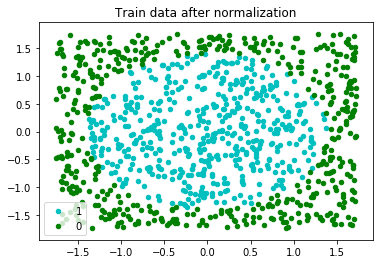

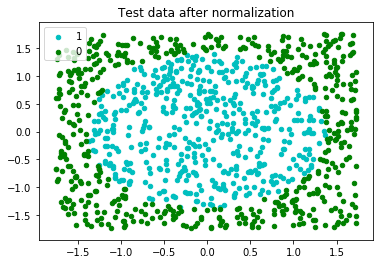

In [3]:
Sample_number = 1000
train_input, train_target = generate_disc_set(Sample_number)
test_input, test_target = generate_disc_set(Sample_number)

plot_disc(train_input, train_target, "Train data before normalization")
    
print("Point outside: ", train_input[(train_target[:,1]==0),0].size(0))
print("Point inside:  ", train_input[(train_target[:,1]==1),0].size(0))

mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

plot_disc(train_input, train_target, "Train data after normalization")
plot_disc(test_input, test_target, "Test data after normalization")

# Module

In [4]:
class Module( ):
    def forward( self , *input ):
        raise NotImplementedError

    def backward ( self , *gradwrtoutput ):
        raise NotImplementedError

    def param ( self ) :
        return []

## Linear

In [5]:
class Linear(Module): 
    
    def __init__(self, weight_size, bias_size):
        self.bias = empty(bias_size)
        self.weight = empty(weight_size)
        x = empty((0,0))
        s = empty((0,0))
        gradwrtbias = empty((0,0))
        gradwrtweight = empty((0,0))
        
    def normalize_parameters(self, mean, std):
        self.bias = self.bias.normal_(mean=mean, std=std)
        self.weight = self.weight.normal_(mean=mean, std=std)
        
    def define_parameters(self, weight, bias):
        self.weight = weight
        self.bias = bias.view((1, bias.numel()))
        
    
    def forward( self , *input ):
        x = input[0]
        self.x = x
        self.s = torch.mm(x, self.weight.t()) + self.bias
        return self.s

    def backward( self , *gradwrtoutput ):
        gradwrtoutput = gradwrtoutput[0]
        self.gradwrtbias = torch.mm(torch.ones((1, self.x.size(dim=0))) ,gradwrtoutput)
        self.gradwrtweight = torch.mm(gradwrtoutput.t(), self.x)
        return torch.mm(gradwrtoutput, self.weight)
        
    def update_parameters(self, eta):
        self.bias -= eta * self.gradwrtbias
        self.weight -= eta * self.gradwrtweight
        
    def param ( self ) :
        return [self.bias, self.weight]

## Loss

In [6]:
class Loss(Module):
    
    def __init__(self):
        output = empty((0,0))
        target_output = empty((0,0))

### MSE

In [7]:
class LossMSE(Loss):
    def __init__(self):
        Loss.__init__(self)
        
    def forward(self, output, target_output):
        self.output = output
        self.target_output = target_output
        loss = (output - target_output).pow(2).mean()  # (dim=0).sum()
        return loss

    def backward(self):
        return 2*(self.output - self.target_output)/self.output.numel()  # size(dim=0)

    def param(self):
        return []

### Cross Entropy

## Activations

In [8]:
class Activation(Module):
    def __init__(self):
        self.s = empty((0,0))

    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

### Tanh

In [9]:
class Tanh(Activation):
    def __init__(self):
        Activation.__init__(self)
        
    def forward(self, x):
        self.s = x
        return x.tanh()

    def backward(self, *gradwrtoutput):
        return (1 - (self.s.tanh()).pow(2)) * (gradwrtoutput[0])
        
    def param(self):
        return []

### ReLU

In [10]:
class Relu(Activation):
    def __init__(self):
        Activation.__init__(self)
    
    def forward(self, x):
        self.s = x
        
        y = empty(self.s.size()).zero_()
        y[x>0] = x[x>0]
        
        return y

    def backward(self, *gradwrtoutput):
        y = empty(gradwrtoutput[0].size()).zero_()
        y[self.s > 0] = gradwrtoutput[0][self.s > 0]
        
        return y

    def param(self):
        return []

### Sigmoid

In [11]:
class Sigmoid(Activation):
    def __init__(self, p_lambda):
        Activation.__init__(self)
        self.p_lambda = p_lambda
    
    def forward(self, x):
        self.s = x
        return 1/(1 + (-self.p_lambda*x).exp())

    def backward(self, *gradwrtoutput):
        return (self.p_lambda * (-self.s * self.p_lambda).exp()) / ((-self.s * self.p_lambda).exp() + 1).pow(2)

    def param(self):
        return []

## Optimizers

In [13]:
class Optimizers():
    def __init__(self):
        self.s = empty((0,0))

    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

### SGD

In [14]:
class Sgd(Optimizers):
    def __init__(self):
        self.s = empty((0,0))

    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

# Sequential

In [15]:
class Sequential():
    def __init__(self):
        self.s = empty((0,0))

    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

### Compute number error

In [16]:
def compute_number_error(output_one_hot, target_one_hot):
    output = output_one_hot.argmax(dim=1)
    target = target_one_hot.argmax(dim=1)
    nb_of_error = (output != target).sum()
    return nb_of_error

In [17]:
A = torch.tensor([[1,2],[3,2],[10,0]])
B = torch.tensor([1,1,1])

print((A.argmax(dim=1) != B).sum())

tensor(2)


# Test 

In [18]:
# Model definition:
hidden_nb = 25

linear_1 = Linear(weight_size=(hidden_nb, 2) , bias_size=(1,hidden_nb))
relu_1 = Relu()
linear_2 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_2 = Relu()
linear_3 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_3 = Relu()
linear_4 = Linear(weight_size=(2, hidden_nb) , bias_size=(1,2))
loss = LossMSE()


## MODEL BACKWARD PASS
def model_forward(x, target_x):
    x = relu_1.forward(linear_1.forward(x))
    x = relu_2.forward(linear_2.forward(x))
    x = relu_3.forward(linear_3.forward(x))
    x = linear_4.forward(x)    
    #print(x[0:4,:])
    l = loss.forward(x, target_x)
    return (x, l)  
    


## MODEL BACKWARD PASS
passes = [loss, linear_4, relu_3, linear_3, relu_2, linear_2, relu_1, linear_1]

def model_backward(passes, eta):
    grad = passes[0].backward()
    for i in range(1, len(passes)):
        grad = passes[i].backward(grad)
        if passes[i].param():    #If we have parameters
            passes[i].update_parameters(eta)
            
    
    return(grad)

In [19]:
#Model iteration
std = 0.1
linear_1.normalize_parameters(mean=0, std=std)
linear_2.normalize_parameters(mean=0, std=std)
linear_3.normalize_parameters(mean=0, std=std)
linear_4.normalize_parameters(mean=0, std=std)
eta = 3e-3
batch_size = 200
epochs_number = 1000

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        _, loss_value = model_forward(train_input.narrow(0, b, batch_size), train_target.narrow(0, b, batch_size)) #.narrow(0, b, batch_size)
        model_backward(passes, eta)
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
        #eta = eta*0.95

0 :  0.4284552037715912
50 :  0.2754216492176056
100 :  0.25315988063812256
150 :  0.250405877828598
200 :  0.2500580847263336
250 :  0.2499464750289917
300 :  0.24984732270240784
350 :  0.24974891543388367
400 :  0.2496512234210968
450 :  0.24955402314662933
500 :  0.2494576871395111
550 :  0.24936151504516602
600 :  0.24926471710205078
650 :  0.24916765093803406
700 :  0.24907052516937256
750 :  0.24897180497646332
800 :  0.24887019395828247
850 :  0.24876481294631958
900 :  0.2486557960510254
950 :  0.2485431432723999


In [20]:
# Test set: 

output, l = model_forward(test_input, test_target)

print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target))

print(output[0:10,:])
print(test_target[0:10,:])

Loss:  0.24860316514968872
Number of errors:  tensor(358)
tensor([[0.5019, 0.4901],
        [0.4945, 0.5054],
        [0.4989, 0.5066],
        [0.5058, 0.4848],
        [0.4962, 0.5069],
        [0.5047, 0.4878],
        [0.4927, 0.5041],
        [0.4991, 0.4977],
        [0.4993, 0.5068],
        [0.4999, 0.5072]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])


In [21]:
print(linear_4.gradwrtweight[:,0:4])
print(linear_3.gradwrtweight[0:4,0:4])
print(linear_2.gradwrtweight[0:4,0:4])
print(linear_1.gradwrtweight[0:4,:])

tensor([[-0.0020,  0.0000, -0.0012,  0.0000],
        [ 0.0019,  0.0000,  0.0013,  0.0000]])
tensor([[ 0.0000, -0.0002,  0.0005, -0.0001],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0003,  0.0004,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0351e-04, 5.6853e-05, 6.7459e-05, 2.1101e-04],
        [2.0023e-04, 2.4291e-04, 1.9473e-04, 5.8788e-05],
        [1.9925e-04, 3.2157e-05, 0.0000e+00, 2.8717e-04]])
tensor([[-1.0367e-03, -7.7662e-04],
        [-6.4018e-04,  1.1046e-03],
        [-4.6851e-05,  1.2677e-04],
        [ 1.4723e-04,  5.2629e-03]])


## Comparison Test

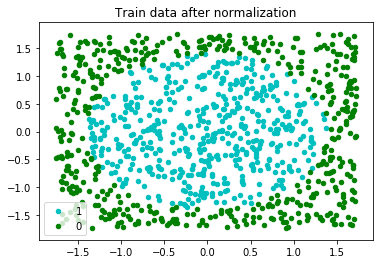

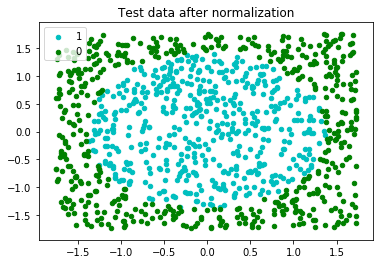

tensor([[-0.8794,  0.5397],
        [ 0.2254, -0.9312],
        [-1.3097,  1.3914],
        [-0.6694, -0.6356],
        [ 0.3082, -0.0241],
        [ 0.8107,  0.2053],
        [ 0.7020,  0.3965],
        [-1.3123,  0.4344],
        [ 1.4293,  0.7466],
        [ 1.3690,  0.0683]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])


In [22]:
import torch.nn as nn

from torch.autograd import Variable
from torch.nn import functional as F

plot_disc(train_input, train_target, "Train data after normalization")
plot_disc(test_input, test_target, "Test data after normalization")

print(train_input[0:10,:])
print(train_target[0:10,:])

hidden_nb = 25

### With autograd

In [23]:
torch.set_grad_enabled(True)
train_input = Variable(train_input.data, requires_grad=True)

class Net(nn.Module):
    def __init__(self, hidden_neurons = 25):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, hidden_neurons)
        self.fc3 = nn.Linear(hidden_neurons, hidden_neurons)
        self.fc4 = nn.Linear(hidden_neurons, 2)

    def forward(self, x):
        x_0 = F.relu(self.fc1(x))
        x_1 = F.relu(self.fc2(x_0))
        x_2 = F.relu(self.fc3(x_1))
        x_3 = self.fc4(x_2)
        y = (x_0, x_1, x_2, x_3)
        return y

model, criterion = Net(), nn.MSELoss()

true_output = model(train_input)
true_loss = criterion(true_output[3], train_target)
print("Loss: ", true_loss.item())
#print(true_output[3][0:10,:])

model.zero_grad()
#true_loss.backward()
# print(model.fc1.bias)
print(torch.autograd.grad(true_loss, model.fc3.weight)[0])


torch.set_grad_enabled(False)


Loss:  0.5393516421318054
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.9204e-03,  0.0000e+00, -4.5242e-03, -2.2897e-05, -7.7381e-03,
         -1.4486e-03, -1.5882e-03, -2.2839e-04, -1.0303e-03,  0.0000e+00,
         -4.0083e-04,  0.0000e+00, -3.6608e-03, -3.0419e-03, -1.6718e-07,
         -2.6604e-03, -7.3837e-05, -9.9737e-04, -6.9770e-03, -1.7377e-03,
          0.0000e+00, -3.3140e-03, -7.1030e-07, -6.7828e-03, -4.6406e-03],
        [-1.4934e-02,  0.0000e+00,  1.2722e-03,  4.5415e-04, -1.8020e-02,
         -2.4015e-03, -7.9223e-03,  2.7619e-04, -7.9983e-03,  0.0000e+00,
         -9.4119e-04,  0.0000e+00, -6.1266e-04, -5.4391e-04,  2.6890e-03,
         -

### Without autograd

In [24]:
linear_1 = Linear(weight_size=(hidden_nb, 2) , bias_size=(1,hidden_nb))
relu_1 = Relu()
linear_2 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_2 = Relu()
linear_3 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_3 = Relu()
linear_4 = Linear(weight_size=(2, hidden_nb) , bias_size=(1,2))
loss = LossMSE()


# linear_1.normalize_parameters(mean=1, std=2)
# linear_2.normalize_parameters(mean=1, std=2)
# linear_3.normalize_parameters(mean=1, std=2)
# linear_4.normalize_parameters(mean=1, std=2)

linear_1.define_parameters(model.fc1.weight, model.fc1.bias)
linear_2.define_parameters(model.fc2.weight, model.fc2.bias)
linear_3.define_parameters(model.fc3.weight, model.fc3.bias)
linear_4.define_parameters(model.fc4.weight, model.fc4.bias)



def model_forward(x, target_x):
    x = relu_1.forward(linear_1.forward(x))
    x = relu_2.forward(linear_2.forward(x))
    x = relu_3.forward(linear_3.forward(x))
    x = linear_4.forward(x)    #relu_4.forward(
    #print(x[0:4,:])
    l = loss.forward(x, target_x)
    print("loss: ", l.item(), "\n")
    return x  
    
our_output = model_forward(train_input, train_target)


## MODEL BACKWARD PASS
def model_backward():
    grad = loss.backward()
    #grad = relu_4.backward(grad)
    grad = linear_4.backward(grad)
    #print(grad.t())
    grad = relu_3.backward(grad)
    grad = linear_3.backward(grad)
    #print(grad.size())
    grad = relu_2.backward(grad)
    grad = linear_2.backward(grad)
    #print(grad.size())
    grad = relu_1.backward(grad)
    grad = linear_1.backward(grad)
    #print(grad.size())
    return(grad)

grad = model_backward()

#print(true_output[3][0:4,:])
print(linear_3.gradwrtweight)

loss:  0.5393517017364502 

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.9204e-03,  0.0000e+00, -4.5242e-03, -2.2897e-05, -7.7381e-03,
         -1.4486e-03, -1.5882e-03, -2.2839e-04, -1.0303e-03,  0.0000e+00,
         -4.0083e-04,  0.0000e+00, -3.6608e-03, -3.0419e-03, -1.6718e-07,
         -2.6604e-03, -7.3837e-05, -9.9737e-04, -6.9770e-03, -1.7377e-03,
          0.0000e+00, -3.3140e-03, -7.1030e-07, -6.7828e-03, -4.6406e-03],
        [-1.4934e-02,  0.0000e+00,  1.2722e-03,  4.5415e-04, -1.8020e-02,
         -2.4015e-03, -7.9223e-03,  2.7619e-04, -7.9983e-03,  0.0000e+00,
         -9.4119e-04,  0.0000e+00, -6.1266e-04, -5.4391e-04,  2.6890e-03,
        